In [18]:
import os
import json
import redis
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 初始化 Redis 客户端，分别对应不同的数据库
r_vectors_titles = redis.Redis(host='localhost', port=6379, db=0)  # 标题向量
r_texts_titles = redis.Redis(host='localhost', port=6379, db=1)  # 原始标题文本
r_texts_abstracts = redis.Redis(host='localhost', port=6379, db=2)  # 原始摘要文本
r_vectors_abstracts = redis.Redis(host='localhost', port=6379, db=3)  # 摘要向量

# 初始化模型和分词器
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

def vectorize_text(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.cpu().numpy()

def process_json_files(json_dir, num_titles):
    processed_titles = 0
    for json_file in sorted(os.listdir(json_dir)):
        if json_file.endswith('.json') and processed_titles < num_titles:
            file_path = os.path.join(json_dir, json_file)
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
                title = data.get('title', None)
                abstract = data.get('abstract', None)
                cache_key = json_file.replace('.json', '')  # 文件名作为缓存键的一部分

                # 处理标题
                if title:
                    title_vector = vectorize_and_cache(title, r_vectors_titles, r_texts_titles, cache_key, prefix='title_')

                # 处理摘要
                if abstract:
                    abstract_vector = vectorize_and_cache(abstract, r_vectors_abstracts, r_texts_abstracts, cache_key, prefix='abstract_')

                processed_titles += 1

def vectorize_and_cache(text, r_vectors, r_texts, cache_key, prefix=''):
    full_key = f"{prefix}{cache_key}"
    cached_vector = r_vectors.get(full_key)
    if cached_vector:
        # 从缓存读取向量
        embedding = np.frombuffer(cached_vector, dtype=np.float32)
    else:
        # 向量化并缓存结果
        embedding = vectorize_text(text)
        r_vectors.set(full_key, embedding.tobytes())
        r_texts.set(full_key, text)  # 存储原始文本
    return embedding

json_dir = 'arxiv'  # 指向您存储 JSON 文件的目录
num_titles = 2000000  # 指定您想要处理的标题数量

process_json_files(json_dir, num_titles)
print("Data processing complete.")


Data processing complete.


Visualization saved to 'vectors_visualization.png'.


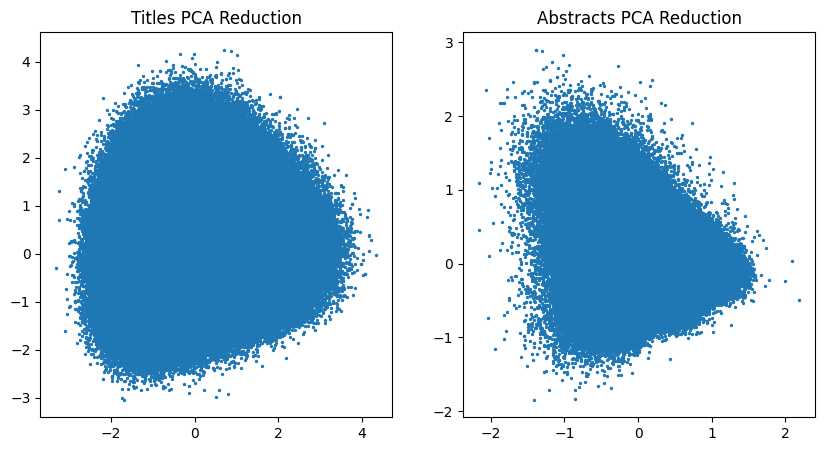

In [1]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import redis

# 连接到Redis
r_vectors_titles = redis.Redis(host='localhost', port=6379, db=0)
r_vectors_abstracts = redis.Redis(host='localhost', port=6379, db=3)

def retrieve_vectors(r_db):
    vectors = []
    keys = r_db.keys()
    for key in keys:
        vector_data = r_db.get(key)
        vector = np.frombuffer(vector_data, dtype=np.float32)
        vectors.append(vector)
    return np.array(vectors)

# 检索向量
title_vectors = retrieve_vectors(r_vectors_titles)
abstract_vectors = retrieve_vectors(r_vectors_abstracts)

# 应用PCA降维
pca = PCA(n_components=3)
title_vectors_reduced = pca.fit_transform(title_vectors)
abstract_vectors_reduced = pca.fit_transform(abstract_vectors)

# 可视化并保存到文件
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(title_vectors_reduced[:, 0], title_vectors_reduced[:, 1], s=2)
plt.title('Titles PCA Reduction')

plt.subplot(1, 2, 2)
plt.scatter(abstract_vectors_reduced[:, 0], abstract_vectors_reduced[:, 1], s=2)
plt.title('Abstracts PCA Reduction')

# 保存图像到文件
plt.savefig('vectors_visualization.png')

print("Visualization saved to 'vectors_visualization.png'.")


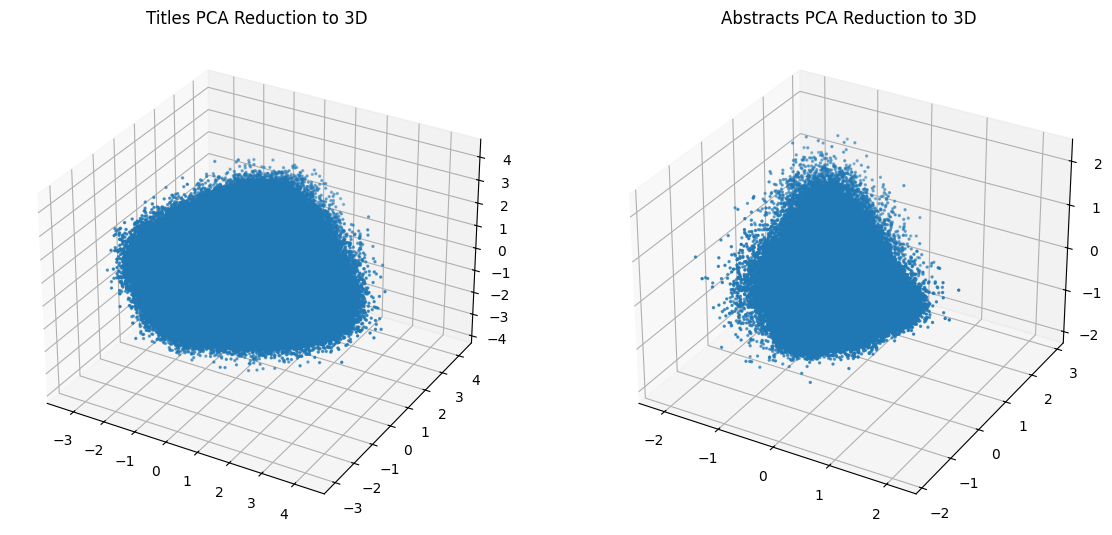

In [3]:
# 应用PCA降维到3D
pca = PCA(n_components=3)
title_vectors_reduced = pca.fit_transform(title_vectors)
abstract_vectors_reduced = pca.fit_transform(abstract_vectors)

# 创建3D可视化并保存到文件
fig = plt.figure(figsize=(14, 7))

# 标题向量的3D可视化
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(title_vectors_reduced[:, 0], title_vectors_reduced[:, 1], title_vectors_reduced[:, 2], s=2)
ax.set_title('Titles PCA Reduction to 3D')

# 摘要向量的3D可视化
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(abstract_vectors_reduced[:, 0], abstract_vectors_reduced[:, 1], abstract_vectors_reduced[:, 2], s=2)
ax.set_title('Abstracts PCA Reduction to 3D')

# 保存图像到文件
plt.savefig('vectors_3d_visualization.png')

In [ ]:
import os
import json
import redis
import numpy as np
from scipy.spatial.distance import cdist
from transformers import AutoTokenizer, AutoModel
import torch

# 初始化 Redis 客户端，分别对应不同的数据库
r_vectors_titles = redis.Redis(host='localhost', port=6379, db=0)  # 标题向量
r_texts_titles = redis.Redis(host='localhost', port=6379, db=1)  # 原始标题文本
r_texts_abstracts = redis.Redis(host='localhost', port=6379, db=2)  # 原始摘要文本
r_vectors_abstracts = redis.Redis(host='localhost', port=6379, db=3)  # 摘要向量

# 初始化模型和分词器
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

def vectorize_text(text):
    """将文本向量化"""
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.cpu().numpy()

def query_vectorize(query):
    """将查询向量化"""
    return vectorize_text(query)

def find_similar_texts(query, r_vectors, r_texts, top_n=10):
    """查找最相似的文本"""
    query_vec = query_vectorize(query)
    keys = r_vectors.keys('*')
    vectors = np.array([np.frombuffer(r_vectors.get(k), dtype=np.float32) for k in keys])
    # 计算查询向量和所有向量的余弦相似度
    distances = cdist(query_vec, vectors, 'cosine').flatten()
    # 获取最相似的top_n个索引
    closest_indices = distances.argsort()[:top_n]
    closest_keys = [keys[i] for i in closest_indices]
    # 从Redis获取原始文本
    similar_texts = [r_texts.get(k).decode('utf-8') for k in closest_keys]
    return similar_texts

# 示例查询
query = "Instance Segmentation"
# 查找最相似的标题
similar_titles = find_similar_texts(query, r_vectors_titles, r_texts_titles)
print("Similar Titles:", similar_titles)
# 查找最相似的摘要
similar_abstracts = find_similar_texts(query, r_vectors_abstracts, r_texts_abstracts)
print("Similar Abstracts:", similar_abstracts)
